In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import pickle
import argparse
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
import xgboost as xgb
import pprint
import matplotlib.pyplot as plt

In [2]:
class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        """
        :param cost_matrix:
        :param rank: rank of the cost matrix
        """
        self.matrix = cost_matrix
        self.rank = rank
        self.pheromone = [[1 / (rank * rank)
                           for j in range(rank)] for i in range(rank)]


class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int,
                 strategy: int):
        """
        :param ant_count:
        :param generations:
        :param alpha: relative importance of pheromone
        :param beta: relative importance of heuristic information
        :param rho: pheromone residual coefficient
        :param q: pheromone intensity
        :param strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density
        """
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]

    # noinspection PyProtectedMember
    def solve(self, graph: Graph, verbose: bool = False):
        """
        :param graph:
        """
        best_cost = float('inf')
        best_solution = []
        avg_costs = []
        best_costs = []
        for gen in range(self.generations):
            # noinspection PyUnusedLocal
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                curr_cost = []
                for i in range(graph.rank - 1):
                    ant._select_next()
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                curr_cost.append(ant.total_cost)
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                # update pheromone
                ant._update_pheromone_delta()
            self._update_pheromone(graph, ants)
            best_costs.append(best_cost)
            avg_costs.append(np.mean(curr_cost))
            if verbose:
                print('Generation #{} best cost: {}, avg cost: {}, path: {}'.format(
                    gen+1, best_cost, avg_costs[-1], best_solution))
        return best_solution, best_cost, avg_costs, best_costs


class _Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []  # tabu list
        self.pheromone_delta = []  # the local increase of pheromone
        # nodes which are allowed for the next selection
        self.allowed = [i for i in range(graph.rank)]
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in
                    range(graph.rank)]  # heuristic information
        start = random.randint(0, graph.rank - 1)  # start from any node
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][
                i] ** self.colony.beta
        # noinspection PyUnusedLocal
        # probabilities for moving to a node in the next step
        probabilities = [0 for i in range(self.graph.rank)]
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)  # test if allowed list contains i
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass  # do nothing
        # select next node by probability roulette
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    # noinspection PyUnusedLocal
    def _update_pheromone_delta(self):
        self.pheromone_delta = [
            [0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        for _ in range(1, len(self.tabu)):
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            if self.colony.update_strategy == 1:  # ant-quality system
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:  # ant-density system
                # noinspection PyTypeChecker
                self.pheromone_delta[i][j] = self.colony.Q / \
                    self.graph.matrix[i][j]
            else:  # ant-cycle system
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost

In [3]:
def plot(points, path: list):
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])
    plt.plot(x, y, 'co')

    for _ in range(1, len(path)):
        i = path[_ - 1]
        j = path[_]
        plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i],
                  color='r', length_includes_head=True)

    # Close the loop and highlight the last and first point path
    i = path[-1]  # Last point index
    j = path[0]  # First point index
    plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i],
              color='b', length_includes_head=True)

    zoom_factor = 0.01
    plt.xlim(min(x) - zoom_factor, max(x) + zoom_factor)
    plt.ylim(min(y) - zoom_factor, max(y) + zoom_factor)
    plt.title("ACO Path By Travel Time")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [4]:
# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))
 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)


booster = xgb.Booster()


filename = "./xgb_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))
# booster.save_model(loaded_model)

# load_model = Booster.save_model(loaded_model)
geolocator = Nominatim(user_agent="aco-application")

[20:00:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [5]:
def time_cost_between_points(loc1, loc2, passenger_count, store_and_fwd_flag=0):
    """
    Calculate the time (in minutes) between two points
    using the trained XGB model
    """
    # Hardcode the date to get consistent calculations
    date_list = [27, 5, 2016]  # May 27, 2016

    year = int(date_list[2])
    month = int(date_list[1])
    day = int(date_list[0])

    my_date = datetime.date(year, month, day)

    model_data = {'passenger_count': passenger_count,
                  'pickup_longitude': loc1['x'],
                  'pickup_latitude': loc1['y'],
                  'dropoff_longitude': loc2['x'],
                  'dropoff_latitude': loc2['y'],
                  'store_and_fwd_flag': bool(store_and_fwd_flag),
                  'pickup_month': my_date.month,
                  'pickup_day': my_date.day,
                  'pickup_weekday': my_date.weekday(),
                  'pickup_hour': 23,
                  'pickup_minute': 10,
                  'latitude_difference': loc2['y'] - loc1['y'],
                  'longitude_difference': loc2['x'] - loc1['x'],
                  'trip_distance': trip_distance_cost(loc1, loc2)
                  }

    df = pd.DataFrame([model_data], columns=model_data.keys())
    pred = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1
    return pred[0]


def trip_distance_cost(loc1, loc2):
    """
    Calculate the manhattan distance between two points using 
    polar coordinates in taxicab geometry https://en.wikipedia.org/wiki/Taxicab_geometry
    """
    return 0.621371 * 6371 * (
        abs(2 * np.arctan2(np.sqrt(np.square(
            np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2))),
            np.sqrt(1-(np.square(np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2)))))) +
        abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2))),
                           np.sqrt(1-(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2)))))))

In [21]:
locations = []
points = []

# df = pd.read_csv("./test.csv")[:15]
df = pd.read_csv("./test.csv")[:100]

In [22]:
from tqdm import tqdm 
for index, row in tqdm(df.iterrows()):
    locations.append({
        'index': index,
        'x': row['pickup_longitude'],
        'y': row['pickup_latitude']
    })
    points.append((row['pickup_longitude'], row['pickup_latitude']))

100it [00:00, 14302.34it/s]


In [23]:
# Build complete cost matrix based on time between points
cost_matrix = []
rank = len(locations)
for i in tqdm(range(rank)):
    row = []
    for j in range(rank):
        row.append(time_cost_between_points(
            locations[i], locations[j],
            1, 0))
    cost_matrix.append(row)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28it/s]


In [24]:
# Pass in user arguments
aco = ACO(ant_count=10, generations=100, alpha=1.0,
          beta=10.0, rho=0.5, q=10.0, strategy=2)

In [25]:
# # Build graph with cost matrix and number of points
graph = Graph(cost_matrix, rank)
# Get results from ant colony, specify whether verbose output
best_path, cost, avg_costs, best_costs = aco.solve(graph, 1)


Generation #1 best cost: 523.7365120649338, avg cost: 547.6179817914963, path: [82, 66, 2, 83, 50, 14, 61, 5, 47, 9, 72, 70, 28, 22, 90, 35, 11, 30, 64, 45, 29, 49, 68, 74, 69, 39, 71, 24, 6, 53, 51, 38, 44, 95, 96, 85, 73, 59, 40, 81, 4, 86, 43, 15, 21, 37, 3, 92, 18, 48, 26, 79, 99, 67, 27, 33, 91, 88, 42, 46, 80, 76, 16, 32, 84, 58, 8, 63, 0, 13, 36, 78, 31, 94, 17, 87, 54, 60, 52, 20, 98, 93, 89, 97, 41, 7, 77, 34, 75, 23, 62, 10, 1, 12, 25, 56, 57, 55, 65, 19]
Generation #2 best cost: 505.03858268260956, avg cost: 510.52010107040405, path: [38, 44, 51, 74, 6, 53, 95, 59, 73, 96, 85, 64, 30, 79, 45, 29, 49, 68, 9, 47, 14, 61, 5, 72, 70, 28, 33, 90, 35, 11, 67, 99, 42, 22, 27, 46, 80, 76, 50, 2, 83, 66, 82, 69, 24, 71, 39, 8, 63, 0, 13, 36, 78, 17, 31, 94, 60, 52, 87, 54, 75, 23, 62, 12, 25, 56, 57, 55, 65, 10, 1, 77, 7, 34, 86, 43, 4, 26, 15, 40, 21, 81, 37, 3, 92, 18, 48, 19, 91, 88, 16, 32, 84, 58, 98, 93, 20, 97, 89, 41]
Generation #3 best cost: 505.03858268260956, avg cost: 542

In [27]:
# Print out and plot final solution
print('Final cost: {} minutes, path: {}'.format(cost, best_path))

# Output the mean and standard deviantion of min costs per generation
print("Min cost mean:", np.mean(best_costs))
print("Min cost standard deviation:", np.std(best_costs))



Final cost: 483.17772817611694 minutes, path: [27, 99, 79, 45, 29, 49, 82, 2, 83, 66, 47, 9, 5, 61, 46, 42, 22, 28, 33, 90, 35, 11, 64, 30, 85, 96, 59, 44, 51, 6, 53, 95, 40, 26, 15, 86, 43, 4, 81, 21, 37, 3, 92, 18, 48, 19, 91, 88, 14, 80, 72, 70, 76, 50, 16, 32, 84, 58, 98, 93, 20, 63, 8, 39, 71, 24, 74, 68, 69, 36, 0, 13, 94, 31, 78, 17, 87, 54, 60, 52, 89, 97, 41, 7, 34, 77, 10, 1, 23, 75, 62, 12, 25, 56, 55, 65, 57, 38, 73, 67]
Min cost mean: 486.8056162619591
Min cost standard deviation: 6.923075992400532


Final path addresses:
['W Times Square Hotel, West 47th Street, Theater District, Times Square, '
 'Manhattan, New York County, New York, 10036, United States',
 '42nd Street–Times Square–Port Authority Bus Terminal, 8th Avenue, Theater '
 'District, Manhattan Community Board 5, Manhattan, New York County, New York, '
 '10036, United States',
 '5th Avenue, Midtown South, Manhattan Community Board 5, Manhattan, New York '
 'County, New York, 10035, United States',
 '347, 5th Avenue, Midtown South, Manhattan Community Board 5, Manhattan, New '
 'York, 10016, United States',
 '5th Avenue & 33rd Street, 5th Avenue, Midtown South, Manhattan Community '
 'Board 5, Manhattan, New York, 10035, United States',
 '1149, Broadway, Manhattan Community Board 5, Manhattan, New York, 10001, '
 'United States',
 '139, 5th Avenue, Manhattan Community Board 5, Manhattan, New York, 10010, '
 'United States',
 '6th Avenue, 14th Street (PATH) underground passage, West Village, Chelsea '
 'District, Manhatta

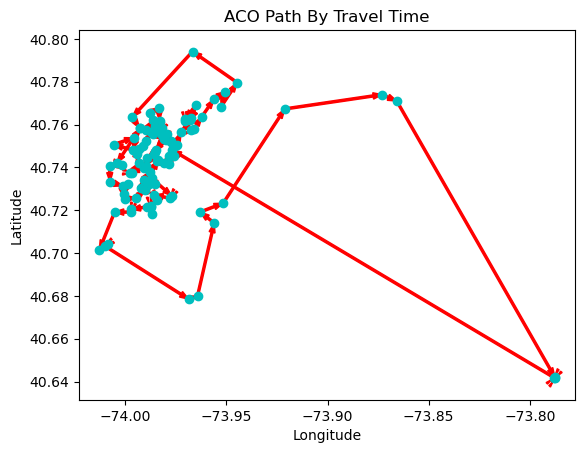

In [28]:
# Print out final addresses in solution
# if args.verbose:
print("Final path addresses:")
try:
    addresses = []
    for p in best_path:
        addresses.append(geolocator.reverse(
            f"{points[p][1]}, {points[p][0]}").address)
    pprint.pprint(addresses)
    
except GeocoderTimedOut as e:
    print(f"Error: geocode failed with message {e}")

plot(points, best_path)



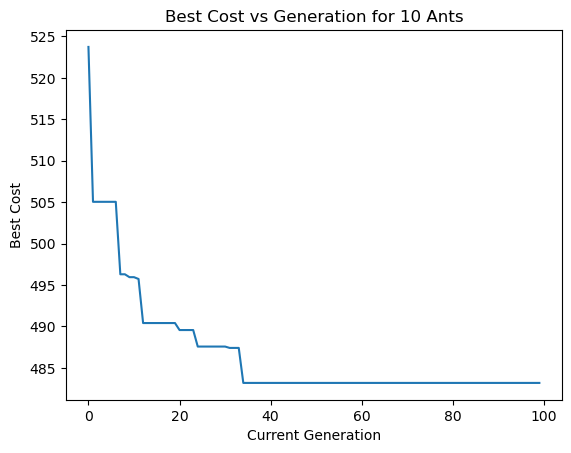

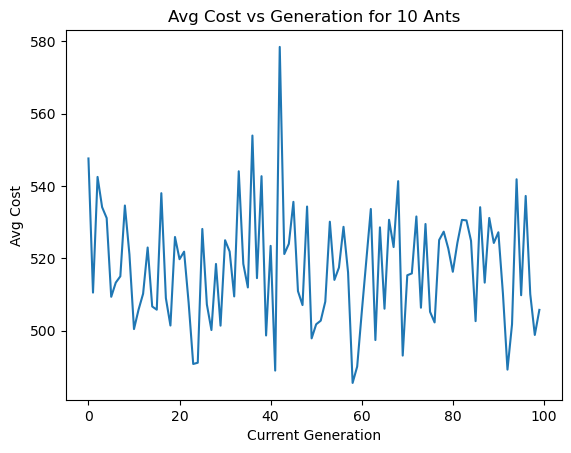

In [29]:
x_values = [i for i in range(100)]
plt.title("Best Cost vs Generation for " + str(10) + " Ants")
plt.ylabel("Best Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, best_costs)
plt.show()

x_values = [i for i in range(100)]
plt.title("Avg Cost vs Generation for " + str(10) + " Ants")
plt.ylabel("Avg Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, avg_costs)
plt.show()